<a href="https://colab.research.google.com/github/ParthikB/encryption/blob/master/encryption_digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


### Grabbing the Data

In [0]:
train = datasets.MNIST('', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test  = datasets.MNIST('', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

## Creating the Dataset Tensor

In [0]:
BATCH_SIZE = 32
HEIGHT, WIDTH = 28, 28
TOTAL_PIXELS = HEIGHT*WIDTH

trainSet = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
testSet  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=True)

#### Viewing one Sample

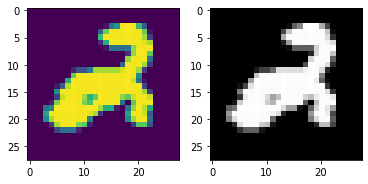

In [4]:
i = np.random.randint(BATCH_SIZE) # a random sample from the first batch
for data in trainSet:
    # data --> one batch containing BATCH_SIZE samples
    x, y = data[0][i], data[1][i]

plt.subplot(1, 2, 1)
plt.imshow(x.view(HEIGHT, WIDTH)) # Reshaping x from (1, Height, Width) --> (Height, Width)

plt.subplot(1, 2, 2)
plt.imshow(x.view(HEIGHT, WIDTH), cmap='gray')

## Creating the Network Structure

In [0]:
l2_size = TOTAL_PIXELS

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(TOTAL_PIXELS, l2_size)
        self.fc2 = nn.Linear(l2_size, l2_size)        
        self.fc3 = nn.Linear(l2_size, TOTAL_PIXELS)        
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x2 = F.sigmoid(self.fc2(x))        
        x = F.sigmoid(self.fc3(x2))        
        
        return x, x2

## Load Pretrained Model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Model Loaded!


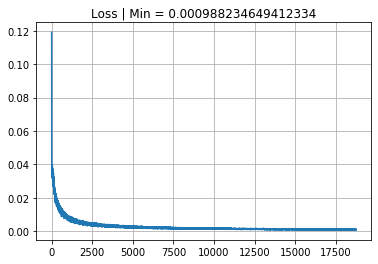

In [20]:
# Defining the Network and Optimizer base
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Loading the model file
model_state_path = '/content/drive/My Drive/Colab Notebooks/encryption/digit_model_state_1575131769__0.0009882'
model_state = torch.load(model_state_path)

# Transferring the Model States to respective variables
net.load_state_dict(model_state['state_dict'])
optimizer.load_state_dict(model_state['optimizer'])
loss_log = model_state['loss_log']

# Plotting the Loss
plt.plot(loss_log)
plt.title(f'Loss | Min = {loss_log[-1].item()}')
plt.grid(1)

print('Model Loaded!')

## Training the Network

  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|          | 20/1875 [00:00<00:09, 196.39it/s]

EPOCH : 1


  1%|▏         | 25/1875 [00:00<00:07, 239.21it/s]

EPOCH : 2


  1%|▏         | 26/1875 [00:00<00:07, 257.87it/s]

EPOCH : 3


  1%|          | 20/1875 [00:00<00:09, 195.27it/s]

EPOCH : 4


  1%|▏         | 25/1875 [00:00<00:07, 241.92it/s]

EPOCH : 5


100%|██████████| 1875/1875 [00:07<00:00, 237.86it/s]


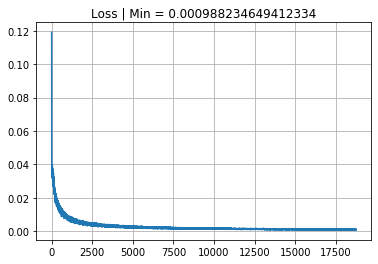

In [0]:
CONTINUE_TRAINING = False
LEARNING_RATE = 0.001 #1e-3
EPOCHS        = 10

if not CONTINUE_TRAINING:
  net = Net().to(device)

  # Define Optimizer
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []

# Iteration Begins
for epoch in range(EPOCHS):
    print('EPOCH :', epoch+1)
    # Iterate over every sample in the batch
    for data in tqdm(trainSet):
        x, _ = data
        net.zero_grad()
        
        #Compute the output
        output, layer2 = net(x.view(-1, TOTAL_PIXELS).to(device))
        
        # Compute Loss
        loss = F.smooth_l1_loss(output, x.view(-1, TOTAL_PIXELS).to(device))
        loss_log.append(loss)
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
    # print(loss)
plt.plot(loss_log)
plt.title(f'Loss | Min = {loss_log[-1].item()}')
plt.grid(1)

## Encryption Decryption

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Total Loss : 0.000988234649412334


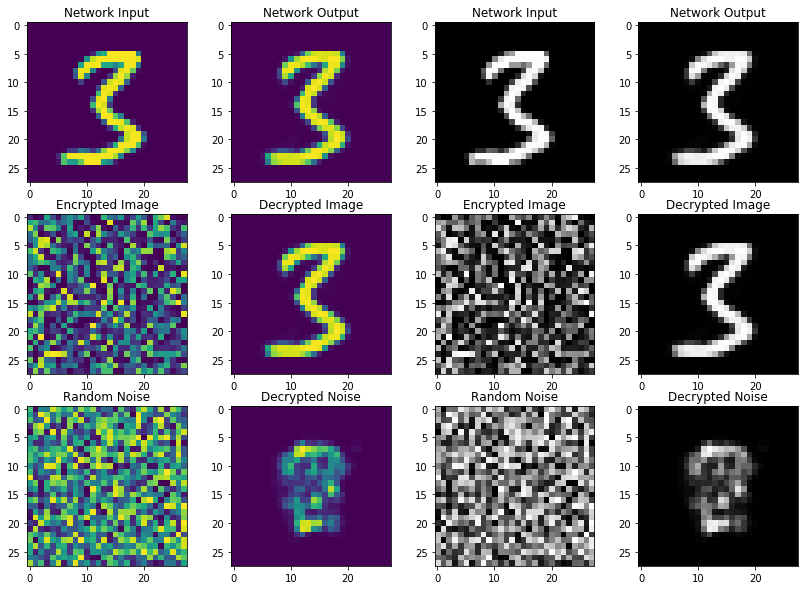

In [72]:
# Selecting a random sample from the dataset
random = np.random.randint(32)

for data in trainSet:
  # print(data)
  sample = data[0][random].view(HEIGHT, WIDTH)
  break


# Passing the sample through the Network and also generating the ENCRYPTED IMAGE
with torch.no_grad():
    # for data in trainSet:
        x = sample
        testOutput, encryptedImage = net(x.view(-1, TOTAL_PIXELS).to(device))


# Converting the tensor into numpy array and reshaping from VECTOR to 2D MATRIX
testOutput  = testOutput.view(HEIGHT, WIDTH)
testOutput  = testOutput.cpu().detach().numpy()*255

encryptedImage  = encryptedImage.view(int(np.sqrt(l2_size)), int(np.sqrt(l2_size)))
# Generating a random noise image to verify that Encrypted Image is just not random
randomNoise     = torch.rand(int(np.sqrt(l2_size)), int(np.sqrt(l2_size)))


# DECRYPTING THE ENCRYPTED_IMAGE/NOISE
with torch.no_grad():
  decryptedImage = F.sigmoid(net.fc3((torch.tensor(encryptedImage)).view(-1, l2_size)).to(device))
  randomNoiseDecrypted = F.sigmoid(net.fc3((randomNoise.view(-1, l2_size).to(device))))


encryptedImage = encryptedImage.cpu().detach().numpy()*255
decryptedImage = decryptedImage.view(HEIGHT, WIDTH).cpu().detach().numpy()*255
randomNoiseDecrypted = randomNoiseDecrypted.view(HEIGHT, WIDTH).cpu().detach().numpy()*255


# PLOTTING THE OUTPUTS
plt.figure(figsize=(14, 10))

plt.subplot(3, 4, 1)
plt.imshow(sample)
plt.title('Network Input')

plt.subplot(3, 4, 2)
plt.imshow(testOutput)
plt.title('Network Output')

plt.subplot(3, 4, 5)
plt.imshow(encryptedImage)
plt.title('Encrypted Image')

plt.subplot(3, 4, 6)
plt.imshow(decryptedImage)
plt.title('Decrypted Image')

plt.subplot(3, 4, 9)
plt.imshow(randomNoise)
plt.title('Random Noise')

plt.subplot(3, 4, 10)
plt.imshow(randomNoiseDecrypted)
plt.title('Decrypted Noise')

# The Original Gray Images
plt.subplot(3, 4, 3)
plt.imshow(sample, cmap='gray')
plt.title('Network Input')

plt.subplot(3, 4, 4)
plt.imshow(testOutput, cmap='gray')
plt.title('Network Output')

plt.subplot(3, 4, 7)
plt.imshow(encryptedImage, cmap='gray')
plt.title('Encrypted Image')

plt.subplot(3, 4, 8)
plt.imshow(decryptedImage, cmap='gray')
plt.title('Decrypted Image')

plt.subplot(3, 4, 11)
plt.imshow(randomNoise, cmap='gray')
plt.title('Random Noise')

plt.subplot(3, 4, 12)
plt.imshow(randomNoiseDecrypted, cmap='gray')
plt.title('Decrypted Noise')

print()
print("Total Loss :", loss_log[-1].item())

In [73]:
print('Difference between Network output and Decrypted Image :', np.sum(testOutput - decryptedImage))

Difference between Network output and Decrypted Image : 0.0


In [0]:
SAVE_MODEL = False

if SAVE_MODEL:

  from google.colab import drive
  drive.mount('/content/drive')

  model_state = {
      'epochs'    : 10,
      'loss_type' : 'smooth_l1_loss',
      'loss_log'  : loss_log,
      'state_dict': net.state_dict(),
      'optimizer' : optimizer.state_dict(),
  }

  torch.save(model_state, f'/content/drive/My Drive/Colab Notebooks/encryption/digit_model_state_{int(time.time())}__{np.round(loss_log[-1].item(), 7)}')
  print(f'Model [digit_model_state_{int(time.time())}__{np.round(loss_log[-1].item(), 7)}] saved successfully!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model [digit_model_state_1575131773__0.0009882] saved successfully!


# Accuracy Check

In [0]:
BATCH_SIZE = 1

trainSet = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
testSet  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=False)

In [113]:
outputs = []

with torch.no_grad():
    for data in tqdm(trainSet):
        x, y = data
        # print(data)
        # break
        testOutput, encryptedImage = net(x.view(-1, TOTAL_PIXELS).to(device))

        # Because Decrypted Image = testOutput. So, to save time, we'll just use the testOutput for verification.
        outputs.append(testOutput.view(BATCH_SIZE, HEIGHT, WIDTH))

  0%|          | 0/60000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 60000/60000 [00:36<00:00, 1666.21it/s]


In [0]:
input_unrolled_size = TOTAL_PIXELS
total_classes       = 10

class Classifier_net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(input_unrolled_size, 64)
        self.fc2 = nn.Linear(64,    64)        
        self.fc3 = nn.Linear(64,    64)        
        self.fc4 = nn.Linear(64,    total_classes)        
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        x = F.relu(self.fc3(x))        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

## Loading Pretrained Model

Model Loaded!


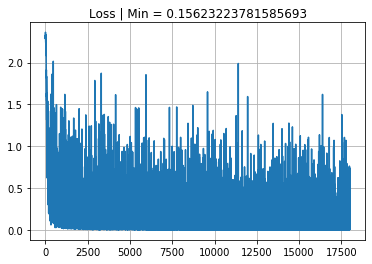

In [75]:
# Defining the Network and Optimizer base
classifier_net = Classifier_net().to(device)
optimizer = optim.Adam(classifier_net.parameters(), lr=0.001)

# Loading the model file
model_state_path = '/content/drive/My Drive/Colab Notebooks/encryption/classification_model'
model_state = torch.load(model_state_path)

# Transferring the Model States to respective variables
classifier_net.load_state_dict(model_state['state_dict'])
optimizer.load_state_dict(model_state['optimizer'])
classifier_loss_log = model_state['loss_log']

# Plotting the Loss
plt.plot(classifier_loss_log)
plt.title(f'Loss | Min = {classifier_loss_log[-1].item()}')
plt.grid(1)

print('Model Loaded!')

## Training the Network

tensor([5])


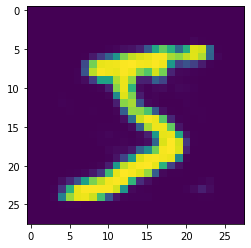

In [120]:
for data in zip(trainSet, outputs):
  # data.append(torch.rand(28, 28))
  # print(data)
  break

# plt.imshow(data[0][0].view(28,28))
plt.imshow(data[1].view(28,28).cpu())
print(data[0][1])

In [121]:
correct, total = 0, 0
decrypted_correct, decrypted_total = 0, 0

with torch.no_grad():
    
    # Train Accuracy
    for data in tqdm(zip(trainSet, outputs)):
        original, net_output = data
        x, y = original
        original_output  = classifier_net(x.view(-1, TOTAL_PIXELS).to(device))
        decrypted_output = classifier_net(net_output.view(-1, TOTAL_PIXELS).to(device))
        
        for idx, i in enumerate(original_output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
        
        for idx, i in enumerate(decrypted_output):
            if torch.argmax(i) == y[idx]:
                decrypted_correct += 1
            decrypted_total += 1

    trainAccuracy = round(correct/total *100, 2)
    decrypted_trainAccuracy = round(decrypted_correct/decrypted_total *100, 2)
    
    # Test Accuracy
    for data in tqdm(zip(testSet, outputs)):
        original, net_output = data
        x, y = original
        original_output  = classifier_net(x.view(-1, TOTAL_PIXELS).to(device))
        decrypted_output = classifier_net(net_output.view(-1, TOTAL_PIXELS).to(device))
        
        for idx, i in enumerate(original_output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
        
        for idx, i in enumerate(decrypted_output):
            if torch.argmax(i) == y[idx]:
                decrypted_correct += 1
            decrypted_total += 1

    testAccuracy = round(correct/total *100, 2)
    decrypted_testAccuracy = round(decrypted_correct/decrypted_total *100, 2)

print()
print('Train Accuracy           :', trainAccuracy, '%')
print('Test Accuracy            :', testAccuracy, '%')
print('Decrypted Train Accuracy :', decrypted_trainAccuracy, '%')
print('Decrypted Test Accuracy  :', decrypted_testAccuracy, '%')

60000it [01:15, 789.92it/s]
10000it [00:12, 797.19it/s]


Train Accuracy           : 96.68 %
Test Accuracy            : 96.58 %
Decrypted Train Accuracy : 96.4 %
Decrypted Test Accuracy  : 84.05 %
